In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
from math import asin, sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from math import floor
from fredapi import Fred
import seaborn as sns
import itertools
from qiskit_aer import AerSimulator
from qiskit.providers.basic_provider import BasicProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
from pgmpy.models import BayesianModel,BayesianNetwork
from pgmpy.base import DAG
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator, BicScore, K2Score, HillClimbSearch
import networkx as nx
import pylab as plt
import pyfolio as pf
import heapq

# silence warnings
import warnings
warnings.filterwarnings('ignore')

/home/aniruddha/miniconda3/envs/capstone_env/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
### Qiskit Runtime service initialization
QiskitRuntimeService.save_account(channel = 'ibm_quantum',
                                  token = 'afbbd92eae66abcc98ea8bfd6269888a2fbeb2cc875b1f30c6cc67ced46d4b5ef84270be2de6c64361ec83180dd3f6f1c616db0debf34cdf5d7816ba9d374597',
                                  instance='ibm-q/open/main',
                                  overwrite=True)
service = QiskitRuntimeService(verify=False)

In [3]:
######## utility functions ############
#### Utility functions for QBN ######

def prob_to_angle(prob):
    return 2*asin(sqrt(prob))


def bit_str_2_arr(bitstring):
	my_state = bitstring[::-1]
	bit_array = np.zeros(len(my_state))
	for i in range(len(my_state)):
		if int(my_state[i]) == 0:
			pass
		else:
			bit_array[i] = int(my_state[i])
	return bit_array



def custom_mcry(circuit,angle,control_qubits,target,control_state):
	# Multi-coltrolled Ry gate #
	Id = []
	for i in range(len(control_state)):
		c = control_state[i]
		if c == '0':
			Id.append(control_qubits[i])			
		else:
			pass
	if len(Id) == 0:
		pass
	else:
		circuit.x(Id)
	circuit.mcry(angle,control_qubits,target)
	if len(Id) == 0:
		pass
	else:
		circuit.x(Id)
	return circuit


def feature_map(x,method = 'default'):
    if method == 'on_axis':
        if x > np.pi/2:
            theta = np.pi 
        elif x <= np.pi/2:
            theta = 0    
        else:
            theta = x
    elif method == 'shift':
        if x > np.pi/2:
            theta = x + np.pi/4 + (x - np.pi/2)
        elif x < np.pi/2:
            theta = x - np.pi/4 - (np.pi/2 - x)
        else:
            theta = x
    elif method == 'default':
        theta = x
    return theta


def encode_data(data_row): # Encoding angle data to quantum circuit Ry gates
    quantum_data = QuantumCircuit(data_row.shape[0],)
    for j in range(len(data_row)):
        quantum_data.ry(feature_map(data_row[j]),j)

    quantum_data.barrier()
    return quantum_data


def my_trade(state,price,prev_log):

# log = {'state':np.nan,'buy_price':np.nan,'sell_price':np.nan,'signal':0,
#       'position':0,'portfolio value':0, 'cash':initial_cash,'last purchase price': np.nan}

    prev_state = prev_log['state']
    trade_log = {'state':state,}

    if state > prev_state: 
        # print("Prev {}, current {} ---> BUY!".format(prev_state,state))
        trade_log['signal'] = +1

        if prev_log['cash'] > 0:
            trade_log['position'] = prev_log['cash']/price
            trade_log['cash'] = 0
            trade_log['buy_price'] = price
            trade_log['sell_price'] = np.nan
            trade_log['last purchase price'] = trade_log['buy_price']
        else:
            trade_log['position'] = prev_log['position']
            trade_log['cash'] = prev_log['cash']
            trade_log['buy_price'] = np.nan
            trade_log['sell_price'] = np.nan
            trade_log['last purchase price'] = 0

    elif state < prev_state: 
        # print("Prev {}, current {} ---> SELL!".format(prev_state,state))
        trade_log['signal'] = -1
        if prev_log['position'] > 0 and price > prev_log['last purchase price']: # include buy price and if purchase price < current price
            trade_log['cash'] = prev_log['position']*price
            trade_log['position'] = 0
            trade_log['buy_price'] = np.nan
            trade_log['sell_price'] = price
            trade_log['last purchase price'] = 0
        else:
            trade_log['position'] = prev_log['position']
            trade_log['cash'] = prev_log['cash']
            trade_log['buy_price'] = np.nan
            trade_log['sell_price'] = np.nan
            trade_log['last purchase price'] = prev_log['last purchase price']
    else:
        # print("Prev {}, current {} ---> HOLD!".format(prev_state,state))
        trade_log['signal'] = 0
        trade_log['buy_price'] = np.nan
        trade_log['sell_price'] = np.nan
        trade_log['position'] = prev_log['position']
        trade_log['cash'] = prev_log['cash']
        trade_log['last purchase price'] = prev_log['last purchase price']

    # print(">>-----",prev_log)
    # print("----->>",trade_log)
    trade_log['portfolio value'] = trade_log['cash'] + (trade_log['position']*price)
    return trade_log


[*********************100%%**********************]  7 of 7 completed


Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2019-01-02,3943.409424,6.8775,0.87247,3.378611,2510.030029,2.661,23.219999
2019-01-03,3836.741211,6.8611,0.88354,3.174486,2447.889893,2.554,25.450001
2019-01-04,3857.717529,6.8711,0.87788,3.377867,2531.939941,2.659,21.379999
2019-01-07,4025.248291,6.8684,0.87639,3.556695,2549.689941,2.682,21.400000
2019-01-08,4030.847900,6.8500,0.87110,3.468149,2574.409912,2.716,20.469999


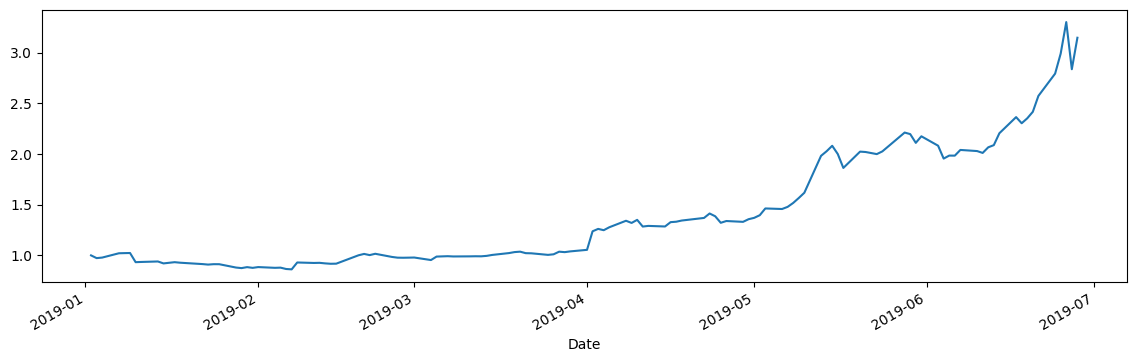

In [37]:
start_date = '2019-01-01'
end_date =   '2019-06-30'

# ^SOX > PHLX semiconductor data
# CNY=X > Yuan to USD forex rate
# EUR=X > EURO to USD forex rate
# ^TNX > CBOE Interest Rate 10 Year T No

target = "BTC-USD"
tickers = [target,"^VIX","NVDA","^GSPC","CNY=X","EUR=X","^TNX"] # "GC=F","^NDX"]

###### Stock Data Collection #######
###### The trading algoorithm will be designed for this Assets #############
data0 = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
data0.dropna(inplace=True)

(data0/data0.iloc[0,:])[target].plot(figsize=(14,4))
data0.head()

In [5]:
# fred = Fred(api_key='8bd22ac3ad2b9cdcbe7c4d5bb66e94ae')

# # 'DCOILWTICO' > West Texas Intermediate (WTI) - Cushing, Oklahoma - crude oil
# # DFF' > Federal fund rate
# series_ids = ['DCOILWTICO'] # ,'DFF']

# data1 = pd.DataFrame()

# # Loop through each series ID and fetch the data
# for series_id in series_ids:
#     df = fred.get_series(series_id)
#     data1[series_id] = df

# # Filter the DataFrame to include data only from 2010 to 2020
# data1 = data1.loc[data0.index]
# data1.head()

In [6]:
##### Joining two dataframes #####
data = data0
# data = pd.concat([data0,data1],axis=1)
# data.head()

In [7]:
####### removing NaN vaalues from the data set ################
data = data.dropna()
print("Number of available samples are",data.shape[0])
print("Number of NaN value on each columns are:\n",data.isna().sum())
# data.head()

Number of available samples are 123
Number of NaN value on each columns are:
 Ticker
BTC-USD    0
CNY=X      0
EUR=X      0
NVDA       0
^GSPC      0
^TNX       0
^VIX       0
dtype: int64


In [8]:
###### Converting to Percentage changes data ##########
data = data.pct_change().dropna()
data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2019-01-03,-0.027050,-0.002385,0.012688,-0.060417,-0.024757,-0.040210,0.096038
2019-01-04,0.005467,0.001457,-0.006406,0.064068,0.034336,0.041112,-0.159921
2019-01-07,0.043427,-0.000393,-0.001697,0.052941,0.007010,0.008650,0.000935
2019-01-08,0.001391,-0.002679,-0.006036,-0.024895,0.009695,0.012677,-0.043458
2019-01-09,0.001104,0.000321,0.002066,0.019667,0.004098,0.004418,-0.023937


In [9]:
#### splitting the data into train and test set
split_ratio = 0.7
split_end = int(data.shape[0]*split_ratio)

train_data = data.iloc[:split_end,:]
test_data = data.iloc[split_end:,:]


print("Size of train data is of {}% is {} samples".format(split_ratio*100,train_data.shape[0]))
print("Size of test data is of {}% is {} samples".format(round(1-split_ratio)*100,test_data.shape[0]))

Size of train data is of 70.0% is 85 samples
Size of test data is of 0% is 37 samples


In [10]:
########### Discretizing/Binarizing percentage change data #############
 
dscrt_train_data = train_data.applymap(lambda x: 1 if x >0 else 0)
dscrt_train_data['forecast'] = dscrt_train_data[target].shift(-1)
dscrt_train_data.dropna(inplace=True)
dscrt_train_data['forecast'] = dscrt_train_data['forecast'].apply(np.int64)
dscrt_train_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX,forecast
Date,,,,,,,,
2019-01-03,0,0,1,0,0,0,1,1
2019-01-04,1,1,0,1,1,1,0,1
2019-01-07,1,0,0,1,1,1,1,1
2019-01-08,1,0,0,0,1,1,0,1
2019-01-09,1,1,1,1,1,1,0,0


In [11]:
####### state distribution of each data columns

for col in dscrt_train_data.columns:
    print("States distribution in {} is {}".format(col,dscrt_train_data[col].value_counts().to_dict()))



States distribution in BTC-USD is {1: 50, 0: 34}
States distribution in CNY=X is {0: 43, 1: 41}
States distribution in EUR=X is {1: 45, 0: 39}
States distribution in NVDA is {1: 49, 0: 35}
States distribution in ^GSPC is {1: 53, 0: 31}
States distribution in ^TNX is {1: 43, 0: 41}
States distribution in ^VIX is {0: 48, 1: 36}
States distribution in forecast is {1: 50, 0: 34}


  0%|          | 0/1000000 [00:00<?, ?it/s]

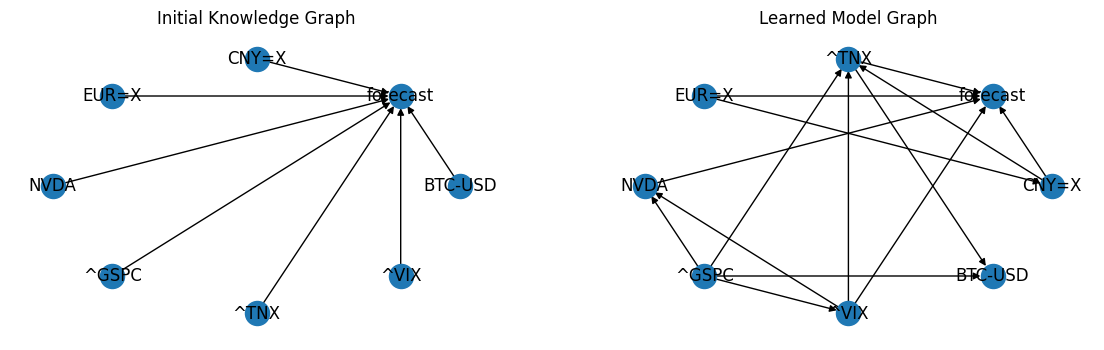

In [12]:
########## Constructing sample knowledge graph of Belief Network #####
 
my_edges = []
for col in dscrt_train_data.columns:
    if col == 'forecast':
        pass
    else:
        my_edges.append((col,'forecast'))
### Sample prior knowledge graph
# print("possible edges will be:",my_edges)

##### Contructing Prior Graph Image using NetworkX ####
G=nx.DiGraph()
G.add_edges_from(my_edges)
label_dict1 = {}
for node in G.nodes():
    label_dict1[node] = node
pos = nx.spring_layout(G)



############ Appliying hillclimb search to best Bayesian network ###########
################## If some prior structure is known ########################

edges = my_edges ## Feeding the prior knowledge graph
model = BayesianNetwork()
model.add_nodes_from(nodes=list(dscrt_train_data.columns))
model.add_edges_from(edges)
hc = HillClimbSearch(dscrt_train_data,state_names=dict(map(lambda e: (e, [0, 1]),dscrt_train_data),
                                                       node_names=list(dscrt_train_data.columns)))
k2 = K2Score(dscrt_train_data)
learned_model = hc.estimate(start_dag=model,scoring_method=k2)
# print("Learned bayesian structure edges are:\n",learned_model.edges())
##### Fitting the Data into Learned Model ###############
learned_model.fit(dscrt_train_data,state_names=dict(map(lambda e: (e, [0, 1]), dscrt_train_data.columns)),
                  estimator=BayesianEstimator, prior_type="K2")

######## Drawing the network ######################
H=nx.DiGraph()
H.add_edges_from(learned_model.edges())
H.add_nodes_from(learned_model.nodes())
label_dict2 = {}
for node in H.nodes():
    label_dict2[node] = node
pos = nx.spring_layout(H)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.title("Initial Knowledge Graph")
nx.draw_circular(G,labels=label_dict1,)

plt.subplot(1,2,2)
plt.title("Learned Model Graph")
nx.draw_circular(H,labels=label_dict2,)
plt.show()

In [13]:
### Optimal Belief Network Configurations #########

print('Nodes of the model:',learned_model.nodes())
print('Edges of the model:',learned_model.edges())

#### Printing CPD table of the dataset ###########
for model in learned_model.get_cpds():
    print("\n\nThe CPD table is:\n",model)


Nodes of the model: ['BTC-USD', 'CNY=X', 'EUR=X', 'NVDA', '^GSPC', '^TNX', '^VIX', 'forecast']
Edges of the model: [('CNY=X', 'forecast'), ('CNY=X', '^TNX'), ('EUR=X', 'forecast'), ('EUR=X', 'CNY=X'), ('NVDA', 'forecast'), ('^GSPC', '^VIX'), ('^GSPC', 'NVDA'), ('^GSPC', '^TNX'), ('^GSPC', 'BTC-USD'), ('^TNX', 'forecast'), ('^TNX', 'BTC-USD'), ('^VIX', 'forecast'), ('^VIX', 'NVDA'), ('^VIX', '^TNX')]


The CPD table is:
 +------------+--------------------+-----+--------------------+
| ^GSPC      | ^GSPC(0)           | ... | ^GSPC(1)           |
+------------+--------------------+-----+--------------------+
| ^TNX       | ^TNX(0)            | ... | ^TNX(1)            |
+------------+--------------------+-----+--------------------+
| BTC-USD(0) | 0.6666666666666666 | ... | 0.4166666666666667 |
+------------+--------------------+-----+--------------------+
| BTC-USD(1) | 0.3333333333333333 | ... | 0.5833333333333334 |
+------------+--------------------+-----+--------------------+


The CPD

In [14]:
#### QuantumCircuit initialization ####
node_list = list(learned_model.nodes())
# cr = ClassicalRegister(1,'signal')
qc= QuantumCircuit([]) #,cr)

for node in node_list:
    qc.add_register(QuantumRegister(1,node)) # Adding qubits with names same as nodes


data_qc = qc.copy()
model_qc = qc.copy()
######### Contructing the QBN from available CPD and ###### 
######### the Learned Belief Network Structure       #######
for i in range(len(learned_model.get_cpds())):
    my_model = learned_model.get_cpds()[i]
    print('\n\nModel state space:',my_model.state_names)



    if len(my_model.variables) == 1:
        cpd = pd.DataFrame(my_model.get_values(),columns=['Probs']).rename_axis(my_model.variable,axis=1)
        cpd['theta'] = 2*np.arctan(np.sqrt(cpd['Probs'].iloc[0]/cpd['Probs'].iloc[1]))
        print(cpd)

        data_qc.ry(prob_to_angle(my_model.values[1]),node_list.index(my_model.variable))
    else:
        print('Control:',my_model.variables[1:],'-----------> Target:',my_model.variable)

        lst = np.array(list(itertools.product([0, 1], repeat=len(my_model.variables)-1)))
        cpd = pd.DataFrame(np.array(lst),columns = my_model.variables[1:])
        cpd['Prob_'+ my_model.variable + str(0)] = my_model.get_values()[0,:]
        cpd['Prob_'+ my_model.variable + str(1)] = my_model.get_values()[1,:]
        cpd['theta'] = 2*np.arctan(np.sqrt(cpd['Prob_'+ my_model.variable + str(0)]/cpd['Prob_'+ my_model.variable + str(1)]))
        print(cpd)

        for j in range(cpd.shape[0]):
            ctrls = [str(int(z)) for z in cpd.iloc[j,:-3].values]
            ctrls = ''.join(ctrls)
            # print("The control state is",ctrls)
            model_qc = custom_mcry(model_qc,cpd.iloc[j,-1],[node_list.index(j) for j in my_model.variables[1:]],node_list.index(my_model.variable),ctrls)

    model_qc.barrier()

# qc.measure_all()
# qc.draw('mpl',fold=60)



Model state space: {'BTC-USD': [0, 1], '^GSPC': [0, 1], '^TNX': [0, 1]}
Control: ['^GSPC', '^TNX'] -----------> Target: BTC-USD
   ^GSPC  ^TNX  Prob_BTC-USD0  Prob_BTC-USD1     theta
0      0     0       0.666667       0.333333  1.910633
1      0     1       0.363636       0.636364  1.294570
2      1     0       0.142857       0.857143  0.775193
3      1     1       0.416667       0.583333  1.403348


Model state space: {'CNY=X': [0, 1], 'EUR=X': [0, 1]}
Control: ['EUR=X'] -----------> Target: CNY=X
   EUR=X  Prob_CNY=X0  Prob_CNY=X1     theta
0      0     0.634146     0.365854  1.842417
1      1     0.404255     0.595745  1.378117


Model state space: {'EUR=X': [0, 1]}
EUR=X     Probs     theta
0      0.465116  1.500972
1      0.534884  1.500972


Model state space: {'NVDA': [0, 1], '^GSPC': [0, 1], '^VIX': [0, 1]}
Control: ['^GSPC', '^VIX'] -----------> Target: NVDA
   ^GSPC  ^VIX  Prob_NVDA0  Prob_NVDA1     theta
0      0     0    0.375000    0.625000  1.318116
1      0     1    0

Depth of the circuit is: 420
Gate operations is:
 OrderedDict([('x', 204), ('unitary', 128), ('ccx', 80), ('mcx_vchain', 64), ('cx', 56), ('cu', 56), ('ry', 24), ('barrier', 8)])


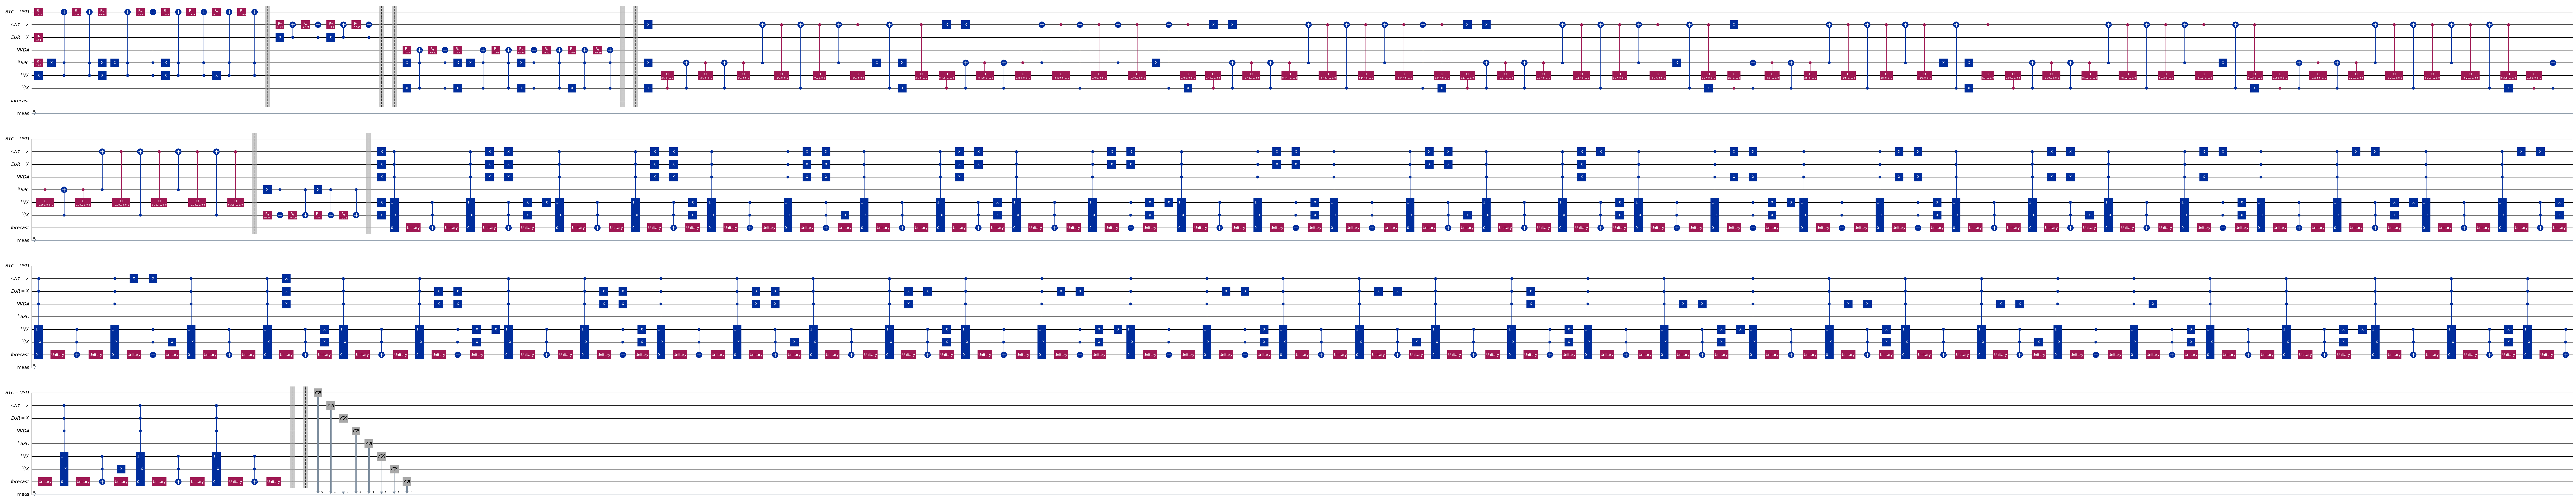

In [15]:
#### Combine the circuit ##############33
qbn_qc = data_qc.compose(model_qc,qubits = range(model_qc.num_qubits))
print("Depth of the circuit is:",model_qc.depth())
print("Gate operations is:\n",model_qc.count_ops())
qbn_qc.measure_all()
qbn_qc.draw('mpl',fold=200)

In [16]:
##### Running on simulator #####
backend = AerSimulator()

# pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
# isa_circuit = pm.run(qbn_qc)

# print("Original Circuit depth is",qbn_qc.depth())
# print("Transpiled Cicuit depth is",isa_circuit.depth())


with Session(service, backend = backend) as session:
    sampler = Sampler(session=session)

    job = sampler.run(qbn_qc, shots=1000)
    result = job.result()
    binary_data = result.quasi_dists[0].binary_probabilities()
    state = max(zip(binary_data.values(), binary_data.keys()))[1]
    print(f"\n\n State with max probability is: {state}")

base_primitive._run_primitive:INFO:2024-07-21 02:25:50,482: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.91562 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 105.41701 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basi



 State with max probability is: 11010010




 State with max probability is: 11010010


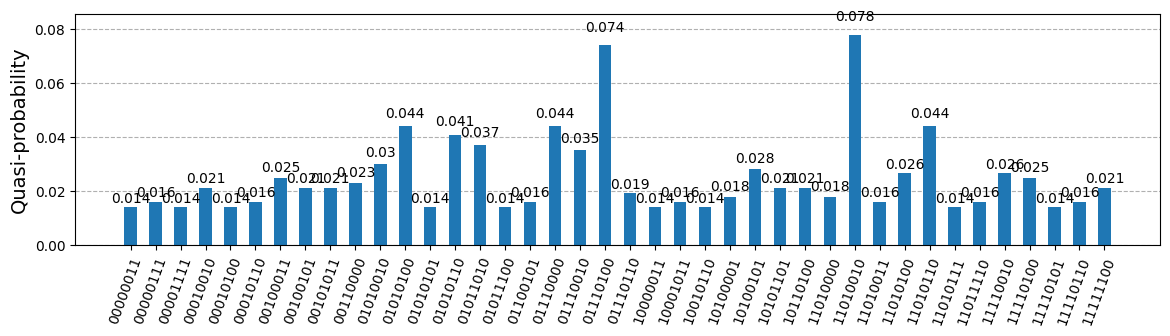

In [17]:
######## Plotting the distribution #############
print(f"\n\n State with max probability is: {state}")

m = 40 # take m largest probability values
top_keys = heapq.nlargest(m, binary_data, key=binary_data.get)
top_states = {key: binary_data[key] for key in top_keys}
plot_histogram(top_states,figsize=(14,3))

In [18]:
train_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2019-01-03,-0.027050,-0.002385,0.012688,-0.060417,-0.024757,-0.040210,0.096038
2019-01-04,0.005467,0.001457,-0.006406,0.064068,0.034336,0.041112,-0.159921
2019-01-07,0.043427,-0.000393,-0.001697,0.052941,0.007010,0.008650,0.000935
2019-01-08,0.001391,-0.002679,-0.006036,-0.024895,0.009695,0.012677,-0.043458
2019-01-09,0.001104,0.000321,0.002066,0.019667,0.004098,0.004418,-0.023937


In [19]:
############ Shifting the mean/referenc e level of the data 
transformed_train_data = train_data.apply(lambda x: (x + (0.5-data.mean())),axis=1)
transformed_train_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2019-01-03,0.462637,0.497625,0.512618,0.437613,0.473910,0.462007,0.597141
2019-01-04,0.495154,0.501467,0.493524,0.562098,0.533002,0.543329,0.341181
2019-01-07,0.533114,0.499617,0.498233,0.550971,0.505677,0.510867,0.502038
2019-01-08,0.491078,0.497330,0.493894,0.473135,0.508362,0.514895,0.457645
2019-01-09,0.490790,0.500331,0.501997,0.517697,0.502764,0.506636,0.477165


In [20]:
####### The Quantum Data: Angle data over bloch sphere ##############
train_quantum_data = 2*np.arctan(np.sqrt((transformed_train_data)/(1-transformed_train_data)))
train_quantum_data['actual'] = dscrt_train_data['forecast']
train_quantum_data.dropna(inplace=True)
train_quantum_data['actual'] = train_quantum_data['actual'].apply(np.int64)
train_quantum_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX,actual
Date,,,,,,,,
2019-01-03,1.496000,1.566046,1.596036,1.445697,1.518592,1.494737,1.766322,1
2019-01-04,1.561104,1.573730,1.557845,1.695314,1.636849,1.657564,1.247560,1
2019-01-07,1.637073,1.570029,1.567262,1.672916,1.582150,1.592533,1.574873,1
2019-01-08,1.552951,1.565457,1.558585,1.517041,1.587520,1.600590,1.485985,1
2019-01-09,1.552376,1.571458,1.574790,1.606198,1.576325,1.584068,1.525111,0


In [21]:
# sns.pairplot(train_quantum_data,hue='actual');

In [22]:
initial_cash = 100000
scenario = {1:'BUY !!!',0:'HOLD !!!',-1:'SELL !!!'}


SIGNALS = []
STATES = []
BUY_PRICE = []
SELL_PRICE = []
POSITIONS = []
PORT_VALUE = []
CASH = []

log = {'state':np.nan,'buy_price':np.nan,'sell_price':np.nan,'signal':0,
       'position':0,'portfolio value':initial_cash,'cash':initial_cash,
       'last purchase price': 0}

# cr = ClassicalRegister(1)
# model_qc.add_register(cr)

z = 0

for i in range(z,train_quantum_data.shape[0]):
    price = data0.loc[train_quantum_data.index[i]][0]
    row = np.append(train_quantum_data.iloc[i,:data.shape[1]].values,0)   
    my_data = encode_data(row) 
    # my_data.append(model_qc,qargs=range(train_quantum_data.iloc[i,:].values.shape[0]),cargs=[0])
    # my_data.append(model_qc,qargs=np.arange(data.shape[1]+1),cargs=[0])
    qbn_circuit = my_data.compose(model_qc,qubits = range(my_data.num_qubits))#,clbits=[0,])
    cr = ClassicalRegister(1)

    qbn_circuit.add_register(cr)
    qbn_circuit.measure(-1,0)

    with Session(service, backend = AerSimulator()) as session:
        sampler = Sampler(session=session)
        result = sampler.run(qbn_circuit,shots=100).result()
        binary_data = result.quasi_dists[0].binary_probabilities()
        state = int(max(zip(binary_data.values(), binary_data.keys()))[1])

    if i == 0:
        log['state'] = state
        if state == 1:
            signal = 1
        else:
            signal = log['signal']

        state = log['state']
        buy_price, sell_price = log['buy_price'],log['sell_price']
        position, port_value, cash = log['position'],log['portfolio value'],log['cash']             
        new_log = log

    elif i == train_quantum_data.shape[0]-1:
        new_log = my_trade(state,price,log)
        state, signal = new_log['state'],new_log['signal']
        buy_price, sell_price = new_log['buy_price'],new_log['sell_price']
        if new_log['position'] > 0:
            cash = new_log['position']*price
            position = 0
            port_value = cash
        else:
            position, port_value, cash = new_log['position'],new_log['portfolio value'],new_log['cash'] 


    else:
        new_log = my_trade(state,price,log)
        state, signal = new_log['state'],new_log['signal']
        buy_price, sell_price = new_log['buy_price'],new_log['sell_price']
        position, port_value, cash = new_log['position'],new_log['portfolio value'],new_log['cash'] 


    log = new_log
    SIGNALS.append(signal)
    BUY_PRICE.append(buy_price)
    SELL_PRICE.append(sell_price)
    STATES.append(state)
    POSITIONS.append(position)
    PORT_VALUE.append(port_value)
    CASH.append(cash)



    print("\n\n{}: The signal for the next day is {} with expected price movement of {}"
          .format(train_quantum_data.index[i].date(),scenario[signal],state))
    print(log)


base_primitive._run_primitive:INFO:2024-07-21 02:25:56,727: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02933 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.36306 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 135.05745 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis



2019-01-03: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'buy_price': nan, 'sell_price': nan, 'signal': 0, 'position': 0, 'portfolio value': 100000, 'cash': 100000, 'last purchase price': 0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 161.30376 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-01-04: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.58980 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 136.32154 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_



2019-01-07: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 176.49484 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-01-08: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 0, 'cash': 100000, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 305.57609 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-01-09: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 99.14041 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'brea



2019-01-10: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 27.181856641587377, 'cash': 0, 'buy_price': 3678.924560546875, 'sell_price': nan, 'last purchase price': 3678.924560546875, 'portfolio value': 100000.0}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.033s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 60.51993 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.96866 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.41384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.35431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.93033 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 10.34164 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 25.95162 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.41153 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.95687 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-01-11: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.181856641587377, 'cash': 0, 'last purchase price': 3678.924560546875, 'portfolio value': 100229.43982214996}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 127.69890 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-01-14: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 100737.38085955322, 'position': 0, 'buy_price': nan, 'sell_price': 3706.05224609375, 'last purchase price': 0, 'portfolio value': 100737.38085955322}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 189.01873 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-01-15: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 27.74618293589723, 'cash': 0, 'buy_price': 3630.67529296875, 'sell_price': nan, 'last purchase price': 3630.67529296875, 'portfolio value': 100737.38085955322}


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'break_loop', 'save_expval', 'unitary', 'quantum_channel', 'rz', 'cu3', 's', 'kra



2019-01-16: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.74618293589723, 'cash': 0, 'last purchase price': 3630.67529296875, 'portfolio value': 101412.48830187679}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.98803 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 245.44001 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'csw



2019-01-17: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.74618293589723, 'cash': 0, 'last purchase price': 3630.67529296875, 'portfolio value': 102066.10870995412}


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 51.31578 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.22441 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.98898 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.21443 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 47.74737 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 10.61106 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.63568 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.02095 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.05414 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02146 (ms)
INFO:qiskit



2019-01-18: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.74618293589723, 'cash': 0, 'last purchase price': 3630.67529296875, 'portfolio value': 101491.07990696035}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 350.05260 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-01-22: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.74618293589723, 'cash': 0, 'last purchase price': 3630.67529296875, 'portfolio value': 100013.25696710167}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.031s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 56.22673 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.05123 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.95243 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.45159 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 47.13917 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.58826 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 18.21136 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.41489 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.49331 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-01-23: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 27.74618293589723, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 3630.67529296875, 'portfolio value': 99473.47990629502}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.029s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 50.71497 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 6.12831 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.70958 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.96132 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 47.85919 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.97879 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 20.11228 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.35050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02885 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 4.41241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-01-24: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.74618293589723, 'cash': 0, 'last purchase price': 3630.67529296875, 'portfolio value': 99910.27229445166}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.074s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 108.59585 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.43279 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 14.80699 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 1.49083 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 148.14997 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 33.16212 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 63.33256 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 14.93931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.49140 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Fixed



2019-01-25: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 27.74618293589723, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 99879.76233157488}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 112.10680 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-01-28: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.74618293589723, 'cash': 0, 'last purchase price': 0, 'portfolio value': 96291.75276303134}


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'break_loop', 'save_expval', 'unitary', 'quantum_channel', 'rz', 'cu3', 's', 'kra



2019-01-29: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.74618293589723, 'cash': 0, 'last purchase price': 0, 'portfolio value': 95672.083494816}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 118.83736 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-01-30: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 96728.23354854759, 'position': 0, 'buy_price': nan, 'sell_price': 3486.181640625, 'last purchase price': 0, 'portfolio value': 96728.23354854759}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.011s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.031s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 63.46583 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.38900 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.88202 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.16222 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 59.68976 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.04428 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 20.42866 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.36289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03123 (ms)
INFO:qiskit.pa



2019-01-31: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 27.97398261038765, 'cash': 0, 'buy_price': 3457.792724609375, 'sell_price': nan, 'last purchase price': 3457.792724609375, 'portfolio value': 96728.23354854759}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.009s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.029s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 56.30589 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.99894 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.74040 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.10516 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 83.17900 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 38.02705 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 29.99306 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.83792 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.pa



2019-02-01: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.97398261038765, 'cash': 0, 'last purchase price': 3457.792724609375, 'portfolio value': 97571.72151785812}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 154.44732 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-02-04: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.97398261038765, 'cash': 0, 'last purchase price': 3457.792724609375, 'portfolio value': 96766.31531784337}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.006s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.041s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 62.96134 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 5.74851 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.55856 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.12901 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 52.91224 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 17.84253 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 18.74900 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.99399 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01669 (ms)
INFO:qiskit.pa



2019-02-05: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.97398261038765, 'cash': 0, 'last purchase price': 3457.792724609375, 'portfolio value': 96967.82224091943}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.54409 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 95.61324 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_s



2019-02-06: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 27.97398261038765, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 3457.792724609375, 'portfolio value': 95496.68169595952}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.031s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 53.98083 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.38549 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.07631 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.73848 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 47.69850 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.51030 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 23.03720 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.54195 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.99001 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-02-07: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 27.97398261038765, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 95096.76165208343}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 5.20682 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 182.55377 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_



2019-02-08: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 102574.4476052531, 'position': 0, 'buy_price': nan, 'sell_price': 3666.7802734375, 'last purchase price': 0, 'portfolio value': 102574.4476052531}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.010s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.038s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 65.77635 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 13.97014 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.07345 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02766 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 4.38404 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 55.62973 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.30955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 22.29524 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.84362 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01621 (ms)
INFO:qiskit.p



2019-02-11: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 102574.4476052531, 'last purchase price': 0, 'portfolio value': 102574.4476052531}


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 59.52096 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.26128 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.74312 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02718 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.33548 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 44.87419 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 18.59140 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.30704 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.86350 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.08084 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02575 (ms)
INFO:qiskit



2019-02-12: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 102574.4476052531, 'last purchase price': 0, 'portfolio value': 102574.4476052531}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.002s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.009s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.046s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 73.36664 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 10.95796 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.88963 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.74253 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 51.95594 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.88853 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.59958 (ms)
INFO:qiskit.passmanager.base_tasks:Pas



2019-02-13: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 102574.4476052531, 'last purchase price': 0, 'portfolio value': 102574.4476052531}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.007s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.037s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 63.24291 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 10.41269 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.34542 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.65853 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 67.16728 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.35859 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 18.29028 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.36568 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02861 (ms)
INFO:qiskit.p



2019-02-14: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 102574.4476052531, 'last purchase price': 0, 'portfolio value': 102574.4476052531}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 122.05768 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-02-15: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 28.329137733397364, 'cash': 0, 'buy_price': 3620.810791015625, 'sell_price': nan, 'last purchase price': 3620.810791015625, 'portfolio value': 102574.4476052531}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 180.53389 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-02-19: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 111817.78323926208, 'position': 0, 'buy_price': nan, 'sell_price': 3947.094482421875, 'last purchase price': 0, 'portfolio value': 111817.78323926208}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.034s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 61.02657 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.63409 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.61125 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.37672 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02813 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 46.61918 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.63976 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 16.96920 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.12791 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.09324 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-02-20: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111817.78323926208, 'last purchase price': 0, 'portfolio value': 111817.78323926208}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 410.84695 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-02-21: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 28.27881681825598, 'cash': 0, 'buy_price': 3954.1181640625, 'sell_price': nan, 'last purchase price': 3954.1181640625, 'portfolio value': 111817.78323926208}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.030s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 53.45392 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 12.46381 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 10.01143 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 4.25220 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 45.20512 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 15.46073 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 14.01877 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.42791 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.69055 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPo



2019-02-22: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 113271.55330239766, 'position': 0, 'buy_price': nan, 'sell_price': 4005.526611328125, 'last purchase price': 0, 'portfolio value': 113271.55330239766}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.007s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.036s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 59.76844 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 6.23202 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.15619 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02861 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.45588 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 45.30072 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 9.64141 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.62018 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.20482 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.pas



2019-02-25: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 29.173426111509677, 'cash': 0, 'buy_price': 3882.6962890625, 'sell_price': nan, 'last purchase price': 3882.6962890625, 'portfolio value': 113271.55330239766}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02742 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.65369 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 176.32413 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_



2019-02-26: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 29.173426111509677, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 3882.6962890625, 'portfolio value': 112444.82569925621}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.030s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 55.93252 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 10.49948 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.03683 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.09491 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 47.13106 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 11.93690 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.89236 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.44651 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.61116 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoi



2019-02-27: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 29.173426111509677, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 112348.24570460971}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.033s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 57.65986 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 11.38759 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.91707 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02480 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.15046 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 52.71864 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.40120 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.59768 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.20930 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02480 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.20442 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoi



2019-02-28: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 29.173426111509677, 'cash': 0, 'last purchase price': 0, 'portfolio value': 112457.29705402214}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.033s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 62.83307 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.53658 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.70640 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02933 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.40922 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 50.89498 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 11.92236 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.66882 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.98231 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.65233 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-03-01: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 29.173426111509677, 'cash': 0, 'last purchase price': 0, 'portfolio value': 112597.2810669117}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.035s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 57.73497 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.12364 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 8.16774 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.22008 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.43800 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.23159 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.79222 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.12750 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03552 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 1.64628 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-03-04: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 29.173426111509677, 'cash': 0, 'last purchase price': 0, 'portfolio value': 109737.50896436897}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.034s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 56.84352 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.01675 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 11.44791 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.21865 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 173.87199 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 51.78118 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 54.71802 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 14.75859 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.96021 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedP



2019-03-05: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 29.173426111509677, 'cash': 0, 'last purchase price': 0, 'portfolio value': 113670.60816523351}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 155.74121 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-03-06: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 113891.38177098997, 'position': 0, 'buy_price': nan, 'sell_price': 3903.942626953125, 'last purchase price': 0, 'portfolio value': 113891.38177098997}


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'break_loop', 'save_expval', 'unitary', 'quantum_channel', 'rz', 'cu3', 's', 'kra



2019-03-07: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 29.117176716573226, 'cash': 0, 'buy_price': 3911.484375, 'sell_price': nan, 'last purchase price': 3911.484375, 'portfolio value': 113891.38177098997}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 8.48889 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 128.72982 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_



2019-03-08: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 29.117176716573226, 'cash': 0, 'last purchase price': 3911.484375, 'portfolio value': 113589.93795295621}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.037s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 70.50920 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 10.47015 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.33137 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.13003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 47.13488 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 16.65187 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.13967 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.73993 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.23756 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoi



2019-03-11: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 29.117176716573226, 'cash': 0, 'last purchase price': 3911.484375, 'portfolio value': 113709.19326462546}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.029s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 55.52101 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.75831 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.87194 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02646 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 1.44410 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 45.75396 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.59422 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 18.66698 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.86722 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.45230 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-03-12: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 29.117176716573226, 'cash': 0, 'last purchase price': 3911.484375, 'portfolio value': 113823.5933439467}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 273.75650 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-03-13: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 29.117176716573226, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 3911.484375, 'portfolio value': 113752.57757358573}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 94.91205 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'brea



2019-03-14: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 29.117176716573226, 'cash': 0, 'last purchase price': 3911.484375, 'portfolio value': 114266.54976864473}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.034s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 59.68809 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 11.29508 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 8.60810 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02766 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.21436 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 45.58921 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 9.56845 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.47689 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.21190 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03624 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.19791 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-03-15: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 29.117176716573226, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 115330.5494127438}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.040s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 64.81004 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 6.12950 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.76098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.46398 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 52.55723 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.52262 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.28496 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.86031 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.89464 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-03-18: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 117415.22837015319, 'position': 0, 'buy_price': nan, 'sell_price': 4032.50732421875, 'last purchase price': 0, 'portfolio value': 117415.22837015319}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.035s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 59.58319 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 5.99384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.36713 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.05963 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 45.91584 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.94065 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.30323 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.45533 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02599 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.38078 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-03-19: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 28.840516659474368, 'cash': 0, 'buy_price': 4071.190185546875, 'sell_price': nan, 'last purchase price': 4071.190185546875, 'portfolio value': 117415.22837015319}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 216.83884 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-03-20: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 28.840516659474368, 'cash': 0, 'last purchase price': 4071.190185546875, 'portfolio value': 117884.92885485051}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 90.24501 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'brea



2019-03-21: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 28.840516659474368, 'cash': 0, 'last purchase price': 4071.190185546875, 'portfolio value': 116207.8697098423}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.79195 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 114.43305 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_



2019-03-22: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 28.840516659474368, 'cash': 0, 'last purchase price': 4071.190185546875, 'portfolio value': 116053.32368929572}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 134.14693 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-03-25: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 28.840516659474368, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 4071.190185546875, 'portfolio value': 114297.0024114663}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 207.00288 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-03-26: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 28.840516659474368, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 114931.78950592877}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 139.01043 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-03-27: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 117873.0997366894, 'position': 0, 'buy_price': nan, 'sell_price': 4087.066162109375, 'last purchase price': 0, 'portfolio value': 117873.0997366894}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.78028 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 166.91518 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cs



2019-03-28: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 117873.0997366894, 'last purchase price': 0, 'portfolio value': 117873.0997366894}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 208.20284 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-03-29: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 28.760939099061627, 'cash': 0, 'buy_price': 4098.37451171875, 'sell_price': nan, 'last purchase price': 4098.37451171875, 'portfolio value': 117873.0997366894}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 168.92743 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-04-01: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 28.760939099061627, 'cash': 0, 'last purchase price': 4098.37451171875, 'portfolio value': 119593.25105913368}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.032s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 57.84011 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.63402 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.75597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.43537 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 43.16616 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.24828 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.25364 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.00305 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.00527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-04-02: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 140349.87194659712, 'position': 0, 'buy_price': nan, 'sell_price': 4879.8779296875, 'last purchase price': 0, 'portfolio value': 140349.87194659712}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.28580 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 315.15431 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save



2019-04-03: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 140349.87194659712, 'last purchase price': 0, 'portfolio value': 140349.87194659712}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.009s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.041s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 78.21989 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.54468 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.03388 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02337 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 4.25816 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 44.72065 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 9.56607 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 22.30620 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.94995 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.pas



2019-04-04: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 140349.87194659712, 'last purchase price': 0, 'portfolio value': 140349.87194659712}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 355.14116 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-04-05: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 27.865546319382805, 'cash': 0, 'buy_price': 5036.68115234375, 'sell_price': nan, 'last purchase price': 5036.68115234375, 'portfolio value': 140349.87194659712}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.035s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 58.48527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.51202 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.20477 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01693 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.86698 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.44229 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.96394 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 18.42046 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.50287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 1.94740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-04-08: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.865546319382805, 'cash': 0, 'last purchase price': 5036.68115234375, 'portfolio value': 147402.35871057812}


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 51.97048 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.41386 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 8.53777 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 4.68540 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 56.25105 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.54606 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.88354 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.00727 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03004 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.08998 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02480 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.06628 (ms)
INFO:qiskit



2019-04-09: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 145039.01206336546, 'position': 0, 'buy_price': nan, 'sell_price': 5204.95849609375, 'last purchase price': 0, 'portfolio value': 145039.01206336546}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 337.08143 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-04-10: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 27.23966610908713, 'cash': 0, 'buy_price': 5324.5517578125, 'sell_price': nan, 'last purchase price': 5324.5517578125, 'portfolio value': 145039.01206336546}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.043s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 64.50629 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 6.89530 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.34909 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.48551 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.04222 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.59255 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 16.96992 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.35884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.35288 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-04-11: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 137954.95649401634}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.029s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 53.48468 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.58784 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.49118 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.96330 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 53.49350 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 17.36736 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.07387 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.58765 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.42734 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-04-12: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 138637.34471165633}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.036s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 60.77719 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.57051 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.12729 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.34699 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01407 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.49498 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.18414 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.37413 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.75995 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.69890 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-04-15: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 138026.34091198872}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.035s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 63.26437 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.82514 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.41322 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.51691 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 48.68579 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.36694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.60721 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.78323 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.37696 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-04-16: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 142614.89458954817}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.030s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 55.58348 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 5.84269 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.40812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02861 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.37155 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03266 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 48.91419 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.32600 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 28.47767 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.00450 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.33071 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-04-17: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 143061.037226412}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.92907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 145.11681 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_



2019-04-18: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 144326.2585343353}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.035s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 314.54158 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.20320 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.78110 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.47066 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 48.56348 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 17.46559 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 20.78962 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.79586 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02742 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.95997 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoi



2019-04-22: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 147076.90618538795}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.033s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 53.30944 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.50384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.71840 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.05460 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.87287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 47.99151 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.91006 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.10796 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.33319 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.00741 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-04-23: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 151789.28861855072}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.038s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 64.89944 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.04155 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.74391 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.71130 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.85380 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 16.98589 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.82823 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.91872 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.97713 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-04-24: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 148861.14421738783}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.031s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 53.72787 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.18412 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.67961 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.28279 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.34502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 9.74965 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.31253 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.96085 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.41630 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint



2019-04-25: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 141932.70588118143}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.06408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02861 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 252.26116 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_



2019-04-26: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 143807.6807306599}


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 51.37396 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 11.34443 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.92225 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02646 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.23176 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.67403 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.08482 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.63201 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.70703 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.31140 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01764 (ms)
INFO:qiski



2019-04-29: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 142936.13112073307}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.034s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 55.93634 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.95269 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.71768 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.27396 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 45.21537 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.76946 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 20.00690 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.11749 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.40295 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-04-30: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 27.23966610908713, 'cash': 0, 'last purchase price': 5324.5517578125, 'portfolio value': 145752.00500352352}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.032s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 57.23429 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 5.60927 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.97635 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.64041 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 45.36843 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 11.89446 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.93933 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.90205 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02718 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.23343 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-05-01: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 147167.66960410302, 'position': 0, 'buy_price': nan, 'sell_price': 5402.697265625, 'last purchase price': 0, 'portfolio value': 147167.66960410302}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.031s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 53.27106 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.06935 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.90506 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.60520 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01788 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 54.59118 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.51769 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 18.92185 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.58193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.27563 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-05-02: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 26.732077373929307, 'cash': 0, 'buy_price': 5505.28369140625, 'sell_price': nan, 'last purchase price': 5505.28369140625, 'portfolio value': 147167.66960410302}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 184.90720 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-05-03: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 26.732077373929307, 'cash': 0, 'last purchase price': 5505.28369140625, 'portfolio value': 154198.3625867123}


In [23]:
train_quantum_data['prices'] = data0.loc[train_quantum_data.index].iloc[z:,0]
train_quantum_data['returns'] = data.loc[train_quantum_data.index].iloc[z:,0]
train_quantum_data['forecast'] = STATES
train_quantum_data['signals'] = SIGNALS
train_quantum_data['positions'] = POSITIONS
train_quantum_data['cash'] = CASH
train_quantum_data['port_value'] = PORT_VALUE



reference = train_quantum_data['actual']
score = accuracy_score(train_quantum_data['actual'],np.array(STATES))*100
print('\n\nQBN prediction accuracy score is:',round(accuracy_score(train_quantum_data['actual'],train_quantum_data['forecast'])*100,2),'%')
print("The confusion matrix is:\n",confusion_matrix(train_quantum_data['actual'],train_quantum_data['forecast']))

strategy = train_quantum_data.iloc[:,7:]
strategy.tail()



QBN prediction accuracy score is: 57.14 %
The confusion matrix is:
 [[13 21]
 [15 35]]


Ticker,actual,prices,returns,forecast,signals,positions,cash,port_value
Date,,,,,,,,
2019-04-29,1,5247.352539,-0.006061,1,0,27.239666,0.000000,142936.131121
2019-04-30,1,5350.726562,0.019700,1,0,27.239666,0.000000,145752.005004
2019-05-01,1,5402.697266,0.009713,0,-1,0.000000,147167.669604,147167.669604
2019-05-02,1,5505.283691,0.018988,1,1,26.732077,0.000000,147167.669604
2019-05-03,0,5768.289551,0.047773,1,0,0.000000,154198.362587,154198.362587


Total profit 54198.36USD with return of 54.2%


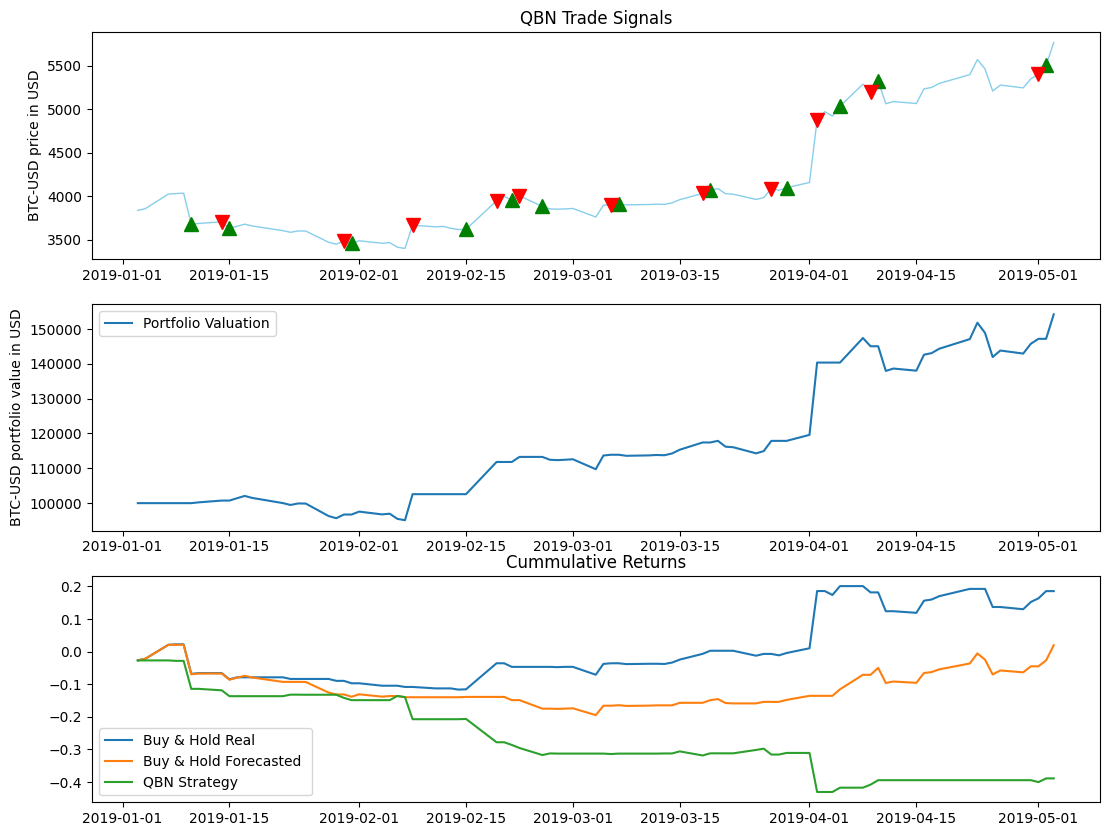

In [24]:
stock_prices = train_quantum_data['prices']
profit = (train_quantum_data['port_value'].iloc[-1]-initial_cash)
print("Total profit {}USD with return of {}%".format(round(profit,2),round(profit*100/initial_cash,2)))

plt.figure(figsize=(13,10))

plt.subplot(3,1,1)
plt.plot(stock_prices, linewidth =1, color = 'skyblue', label = target)
plt.plot(stock_prices.index, BUY_PRICE, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
plt.plot(stock_prices.index, SELL_PRICE, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
plt.ylabel('{} price in USD'.format(target))
plt.title('QBN Trade Signals')


plt.subplot(3,1,2)
plt.plot(strategy.index,strategy['port_value'])
plt.legend(['Portfolio Valuation'])
plt.ylabel('{} portfolio value in USD'.format(target))

plt.subplot(3,1,3)
plt.title('Cummulative Returns')
plt.plot(strategy.index,(1+strategy['returns']*strategy['actual']).cumprod()-1)
plt.plot(strategy.index,(1+strategy['returns']*strategy['forecast']).cumprod()-1)
plt.plot(strategy.index,(1+strategy['returns']*strategy['signals']).cumprod()-1)
plt.legend(['Buy & Hold Real','Buy & Hold Forecasted ','QBN Strategy'])


plt.show()

In [25]:
# pf.create_simple_tear_sheet(strategy['returns']*strategy['signals'])

In [26]:
# pf.create_simple_tear_sheet(strategy['returns']*strategy['signals'])

In [27]:
# pf.create_returns_tear_sheet(strategy['returns']*strategy['signals'])

## **On Test Data**

In [28]:
test_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2019-05-07,0.014390,0.004455,-0.001432,-0.037476,-0.016512,-0.020800,0.251295
2019-05-08,0.026238,0.001833,0.000963,0.004679,-0.001605,0.013889,0.004141
2019-05-09,0.032106,0.000885,-0.000649,-0.021447,-0.003021,-0.010073,-0.015464
2019-05-10,0.033091,0.006561,-0.002116,-0.008050,0.003720,-0.000814,-0.160209
2019-05-13,0.225129,-0.000498,-0.001279,-0.061426,-0.024131,-0.020367,0.281172


In [29]:
############ Shifting the mean/referenc e level of the data 
transformed_test_data = test_data.apply(lambda x: (x + (0.5-data.mean())),axis=1)
transformed_test_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2019-05-07,0.504076,0.504465,0.498499,0.460555,0.482155,0.481417,0.752398
2019-05-08,0.515925,0.501843,0.500894,0.502709,0.497061,0.516106,0.505244
2019-05-09,0.521792,0.500895,0.499281,0.476584,0.495645,0.492145,0.485639
2019-05-10,0.522777,0.506571,0.497814,0.489981,0.502387,0.501403,0.340894
2019-05-13,0.714816,0.499511,0.498651,0.436604,0.474536,0.481851,0.782275


In [30]:
####### The Quantum Data: Angle data over bloch sphere ##############
test_quantum_data = 2*np.arctan(np.sqrt((transformed_test_data)/(1-transformed_test_data)))
test_quantum_data['actual'] = test_data[target].apply(lambda x: 1 if x >0 else 0)
test_quantum_data['actual'] = test_quantum_data['actual'].shift(-1)
test_quantum_data.dropna(inplace=True)
test_quantum_data['actual'] = test_quantum_data['actual'].apply(np.int64)
test_quantum_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX,actual
Date,,,,,,,,
2019-05-07,1.578949,1.579726,1.567793,1.491824,1.535098,1.533623,2.099943,1
2019-05-08,1.602651,1.574482,1.572584,1.576215,1.564918,1.603015,1.581284,1
2019-05-09,1.614395,1.572586,1.569359,1.523947,1.562086,1.555086,1.542071,1
2019-05-10,1.616367,1.583939,1.566424,1.550756,1.575570,1.573603,1.246953,1
2019-05-13,2.014881,1.569819,1.568098,1.443662,1.519846,1.534490,2.170684,1


In [31]:
initial_cash = 100000
scenario = {1:'BUY !!!',0:'HOLD !!!',-1:'SELL !!!'}


SIGNALS_TEST = []
STATES_TEST = []
BUY_PRICE_TEST = []
SELL_PRICE_TEST = []
POSITIONS_TEST = []
PORT_VALUE_TEST = []
CASH_TEST = []

log = {'state':np.nan,'buy_price':np.nan,'sell_price':np.nan,'signal':0,
       'position':0,'portfolio value':initial_cash,'cash':initial_cash,
       'last purchase price': 0}

# cr = ClassicalRegister(1)
# model_qc.add_register(cr)

z = 0

for i in range(z,test_quantum_data.shape[0]):
    price = data0.loc[test_quantum_data.index[i]][0]
    row = np.append(test_quantum_data.iloc[i,:data.shape[1]].values,0)   
    my_data = encode_data(row) 
    # my_data.append(model_qc,qargs=range(train_quantum_data.iloc[i,:].values.shape[0]),cargs=[0])
    # my_data.append(model_qc,qargs=np.arange(data.shape[1]+1),cargs=[0])
    qbn_circuit = my_data.compose(model_qc,qubits = range(my_data.num_qubits))#,clbits=[0,])
    cr = ClassicalRegister(1)

    qbn_circuit.add_register(cr)
    qbn_circuit.measure(-1,0)

    with Session(service, backend = AerSimulator()) as session:
        sampler = Sampler(session=session)
        result = sampler.run(qbn_circuit,shots=100).result()
        binary_data = result.quasi_dists[0].binary_probabilities()
        state = int(max(zip(binary_data.values(), binary_data.keys()))[1])

    if i == 0:
        log['state'] = state
        if state == 1:
            signal = 1
        else:
            signal = log['signal']

        state = log['state']
        buy_price, sell_price = log['buy_price'],log['sell_price']
        position, port_value, cash = log['position'],log['portfolio value'],log['cash']             
        new_log = log

    elif i == test_quantum_data.shape[0]-1:
        new_log = my_trade(state,price,log)
        state, signal = new_log['state'],new_log['signal']
        buy_price, sell_price = new_log['buy_price'],new_log['sell_price']
        if new_log['position'] > 0:
            cash = new_log['position']*price
            position = 0
            port_value = cash
        else:
            position, port_value, cash = new_log['position'],new_log['portfolio value'],new_log['cash'] 


    else:
        new_log = my_trade(state,price,log)
        state, signal = new_log['state'],new_log['signal']
        buy_price, sell_price = new_log['buy_price'],new_log['sell_price']
        position, port_value, cash = new_log['position'],new_log['portfolio value'],new_log['cash'] 


    log = new_log
    SIGNALS_TEST.append(signal)
    BUY_PRICE_TEST.append(buy_price)
    SELL_PRICE_TEST.append(sell_price)
    STATES_TEST.append(state)
    POSITIONS_TEST.append(position)
    PORT_VALUE_TEST.append(port_value)
    CASH_TEST.append(cash)



    print("\n\n{}: The signal for the next day is {} with expected price movement of {}"
          .format(test_quantum_data.index[i].date(),scenario[signal],state))
    print(log)


base_primitive._run_primitive:INFO:2024-07-21 02:26:54,119: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 1.96791 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.05078 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 350.36707 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis



2019-05-07: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'buy_price': nan, 'sell_price': nan, 'signal': 0, 'position': 0, 'portfolio value': 100000, 'cash': 100000, 'last purchase price': 0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 172.68300 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-05-08: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 50.10843 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.29976 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.44605 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.18694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 44.78097 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 11.41191 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 16.38412 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.60491 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.65901 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit



2019-05-09: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 55.67789 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.66294 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.86310 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02956 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 4.65250 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 46.97585 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.91094 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 15.83052 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.04835 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02265 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.53909 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit



2019-05-10: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.030s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 52.55771 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.63464 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.26547 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.47025 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 52.73128 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.51595 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 18.14508 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.49030 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.60162 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-05-13: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 0, 'cash': 100000, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 55.71103 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.40967 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.22413 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.83735 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02623 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.07751 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.35645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 20.83254 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.03078 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.03006 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03123 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02408 (ms)
INFO:qiskit



2019-05-14: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 12.508731069855644, 'cash': 0, 'buy_price': 7994.416015625, 'sell_price': nan, 'last purchase price': 7994.416015625, 'portfolio value': 100000.0}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.035s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 60.17160 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.11107 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.33342 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.03362 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 1.90687 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 43.43867 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.22596 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 20.35117 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.87199 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.01814 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-05-15: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 12.508731069855644, 'cash': 0, 'last purchase price': 7994.416015625, 'portfolio value': 102636.23950408745}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 275.34461 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-05-16: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 12.508731069855644, 'cash': 0, 'last purchase price': 7994.416015625, 'portfolio value': 98630.20843894701}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.029s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 57.99937 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 6.47712 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.23560 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.81715 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 47.11294 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.89027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.90667 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.34997 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02694 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.78489 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-05-17: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 12.508731069855644, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 7994.416015625, 'portfolio value': 91862.81391234751}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.029s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 60.63652 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 5.59592 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.02341 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.81422 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 48.76280 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 11.69896 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 20.30873 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.82931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.55172 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-05-20: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 12.508731069855644, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 99798.52269931576}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.286s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 309.61180 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.52776 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.40130 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 4.56786 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 46.94080 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 11.98339 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 15.84291 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.81279 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01478 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.01957 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoi



2019-05-21: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 99611.12382886394, 'position': 0, 'buy_price': nan, 'sell_price': 7963.32763671875, 'last purchase price': 0, 'portfolio value': 99611.12382886394}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.029s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 58.75349 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.92806 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.32189 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.60274 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01359 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 50.58551 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 11.73496 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 21.80958 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.50873 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.55983 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-05-23: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 12.638043833759696, 'cash': 0, 'buy_price': 7881.8466796875, 'sell_price': nan, 'last purchase price': 7881.8466796875, 'portfolio value': 99611.12382886394}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.092s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 118.26348 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.94189 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.09660 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02480 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.09467 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 135.73980 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 23.73981 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 45.70246 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 13.19909 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 8.00872 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedP



2019-05-24: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 12.638043833759696, 'cash': 0, 'last purchase price': 7881.8466796875, 'portfolio value': 100944.75217023747}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 117.12241 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-05-28: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 12.638043833759696, 'cash': 0, 'last purchase price': 7881.8466796875, 'portfolio value': 110203.26089863697}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 85.32715 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'brea



2019-05-29: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 109438.98013452622, 'position': 0, 'buy_price': nan, 'sell_price': 8659.4873046875, 'last purchase price': 0, 'portfolio value': 109438.98013452622}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.041s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 68.78471 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 6.59490 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.00121 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 4.54617 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01526 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 49.01791 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 11.27625 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.21439 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.92134 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.03030 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-05-30: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 109438.98013452622, 'last purchase price': 0, 'portfolio value': 109438.98013452622}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.037s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 58.87198 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.39305 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.55396 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.63636 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01907 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 44.54803 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 10.61296 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.77434 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.10962 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.40247 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-05-31: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 12.763304589911591, 'cash': 0, 'buy_price': 8574.501953125, 'sell_price': nan, 'last purchase price': 8574.501953125, 'portfolio value': 109438.98013452622}


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'break_loop', 'save_expval', 'unitary', 'quantum_channel', 'rz', 'cu3', 's', 'kra



2019-06-03: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 12.763304589911591, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 8574.501953125, 'portfolio value': 104773.90505776106}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.36473 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 356.61578 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_



2019-06-04: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 12.763304589911591, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 98376.6289324308}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.033s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 55.70054 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.59659 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.18282 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.20935 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 48.65456 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 11.32846 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 22.95589 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.49340 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.52144 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-06-05: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 12.763304589911591, 'cash': 0, 'last purchase price': 0, 'portfolio value': 99863.04911848763}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.038s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 61.45310 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 10.74672 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.03342 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.21293 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 50.01378 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.24432 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.91439 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.66125 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.91967 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoi



2019-06-06: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 12.763304589911591, 'cash': 0, 'last purchase price': 0, 'portfolio value': 99834.8676422398}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.43831 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01121 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 117.74611 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_



2019-06-07: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 12.763304589911591, 'cash': 0, 'last purchase price': 0, 'portfolio value': 102667.3989130169}


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'break_loop', 'save_expval', 'unitary', 'quantum_channel', 'rz', 'cu3', 's', 'kra



2019-06-10: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 12.763304589911591, 'cash': 0, 'last purchase price': 0, 'portfolio value': 102110.64337485825}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 276.22700 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-06-11: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 101183.8330206623, 'position': 0, 'buy_price': nan, 'sell_price': 7927.71435546875, 'last purchase price': 0, 'portfolio value': 101183.8330206623}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 100.91996 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-06-12: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 12.421507986248546, 'cash': 0, 'buy_price': 8145.857421875, 'sell_price': nan, 'last purchase price': 8145.857421875, 'portfolio value': 101183.8330206623}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.031s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 56.27918 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 6.77586 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.44818 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02384 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 4.82583 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 46.27848 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 17.10153 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 16.29090 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.86961 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.64041 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-06-13: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 102240.48606525814, 'position': 0, 'buy_price': nan, 'sell_price': 8230.923828125, 'last purchase price': 0, 'portfolio value': 102240.48606525814}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.037s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 66.41197 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 9.75871 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.01649 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02503 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.57874 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 47.37616 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.27872 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 24.93978 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.14929 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02003 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.58367 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-06-14: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 11.760116162040637, 'cash': 0, 'buy_price': 8693.8330078125, 'sell_price': nan, 'last purchase price': 8693.8330078125, 'portfolio value': 102240.48606525814}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.009s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.035s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 62.37030 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 10.29015 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.50308 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02599 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.28064 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02360 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 48.15602 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 11.37805 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.02676 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.80707 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01335 (ms)
INFO:qiskit.p



2019-06-17: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 11.760116162040637, 'cash': 0, 'last purchase price': 8693.8330078125, 'portfolio value': 109608.4285305454}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.039s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 63.93170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.57194 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.40202 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.47662 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01931 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 53.60246 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 14.04905 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 18.56232 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 2.84576 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 7.74026 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-06-18: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 106802.58425296226, 'position': 0, 'buy_price': nan, 'sell_price': 9081.7626953125, 'last purchase price': 0, 'portfolio value': 106802.58425296226}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 201.73407 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('rccx', 3), ('cu', 2), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-06-19: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 11.516939323741735, 'cash': 0, 'buy_price': 9273.521484375, 'sell_price': nan, 'last purchase price': 9273.521484375, 'portfolio value': 106802.58425296226}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.032s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 53.72477 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 7.37739 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 7.19190 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.79181 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02575 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 47.35756 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 10.48684 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 21.30532 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.98231 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.10612 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-06-20: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 11.516939323741735, 'cash': 0, 'last purchase price': 9273.521484375, 'portfolio value': 109723.72544710107}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 358.44731 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-06-21: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 116834.24329633941, 'position': 0, 'buy_price': nan, 'sell_price': 10144.556640625, 'last purchase price': 0, 'portfolio value': 116834.24329633941}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.029s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 55.69887 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 6.91414 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.61898 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02718 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.18170 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 52.74630 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 16.75177 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 17.96174 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 4.37880 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02122 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 2.39205 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-06-24: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 116834.24329633941, 'last purchase price': 0, 'portfolio value': 116834.24329633941}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.034s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 55.58324 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 8.23045 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 5.13482 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.18813 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 53.47157 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 13.86857 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 19.87576 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 6.31523 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02527 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.23153 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoin



2019-06-25: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 116834.24329633941, 'last purchase price': 0, 'portfolio value': 116834.24329633941}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 245.90993 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('ccx', 3), ('measure', 1), ('x', 1), ('barrier', 8), ('u2', 1), ('cu', 2), ('rccx', 3), ('unitary', 1), ('ry', 1), ('cx', 2), ('u1', 1)} to target basis {'cu1', 'r', 'rzz', 'measure', 'qerror_loc', 'mcswap', 'set_matrix_product_state', 'mcr', 'mcy', 'swap', 'delay', 'u', 'ryy', 'save_amplitudes', 'mcu1', 'cx', 'save_state', 'ccz', 'save_superop', 'mcu3', 'csx', 'save_probabilities_dict', 'roerror', 'diagonal', 'set_density_matrix', 'mcry', 'p', 'cz', 'pauli', 'if_else', 'while_loop', 'for_loop', 'mcrz', 'mcphase', 'id', 'cy', 'rx', 'x', 'snapshot', 'cu2', 't', 'save_probabilities', 'sxdg', 'save_statevector_dict', 'u3', 'h', 'z', 'mcp', 'mcx', 'initialize', 'store', 'cswap', 'save_stabilizer', 'set_stabilizer', 'cu', 'save_density_matrix', 'save_unitary', 'save_clifford', 'ccx', 'mcu', 'switch_case', 'rzx', 'y', 'bre



2019-06-26: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 8.976042242888559, 'cash': 0, 'buy_price': 13016.2314453125, 'sell_price': nan, 'last purchase price': 13016.2314453125, 'portfolio value': 116834.2432963394}


INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.002s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.010s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.034s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 65.39369 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: AerBackendRebuildGateSetsFromCircuit - 6.90627 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Depth - 3.88026 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 3.80826 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.02408 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Optimize1qGatesDecomposition - 43.15948 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 12.24232 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: GatesInBasis - 20.34831 (ms)
INFO:qiskit.passmanager.base_tasks:Pass



2019-06-27: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 8.976042242888559, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 13016.2314453125, 'portfolio value': 100377.3448003047}


In [32]:
test_quantum_data['prices'] = data0.loc[test_quantum_data.index].iloc[z:,0]
test_quantum_data['returns'] = data.loc[test_quantum_data.index].iloc[z:,0]
test_quantum_data['forecast'] = STATES_TEST
test_quantum_data['signals'] = SIGNALS_TEST
test_quantum_data['positions'] = POSITIONS_TEST
test_quantum_data['cash'] = CASH_TEST
test_quantum_data['port_value'] = PORT_VALUE_TEST



reference = test_quantum_data['actual']
score = accuracy_score(test_quantum_data['actual'],np.array(STATES_TEST))*100
print('\n\nQBN prediction accuracy score is:',round(accuracy_score(test_quantum_data['actual'],test_quantum_data['forecast'])*100,2),'%')
print("The confusion matrix is:\n",confusion_matrix(test_quantum_data['actual'],test_quantum_data['forecast']))

test_strategy = test_quantum_data.iloc[:,7:]
test_strategy.tail()



QBN prediction accuracy score is: 44.44 %
The confusion matrix is:
 [[ 3 10]
 [10 13]]


Ticker,actual,prices,returns,forecast,signals,positions,cash,port_value
Date,,,,,,,,
2019-06-21,1,10144.556641,0.064804,0,-1,0.000000,116834.243296,116834.243296
2019-06-24,1,11011.102539,0.085420,0,0,0.000000,116834.243296,116834.243296
2019-06-25,1,11790.916992,0.070821,0,0,0.000000,116834.243296,116834.243296
2019-06-26,0,13016.231445,0.103920,1,1,8.976042,0.000000,116834.243296
2019-06-27,1,11182.806641,-0.140857,0,-1,0.000000,100377.344800,100377.344800


Total profit 377.34USD with return of 0.38%


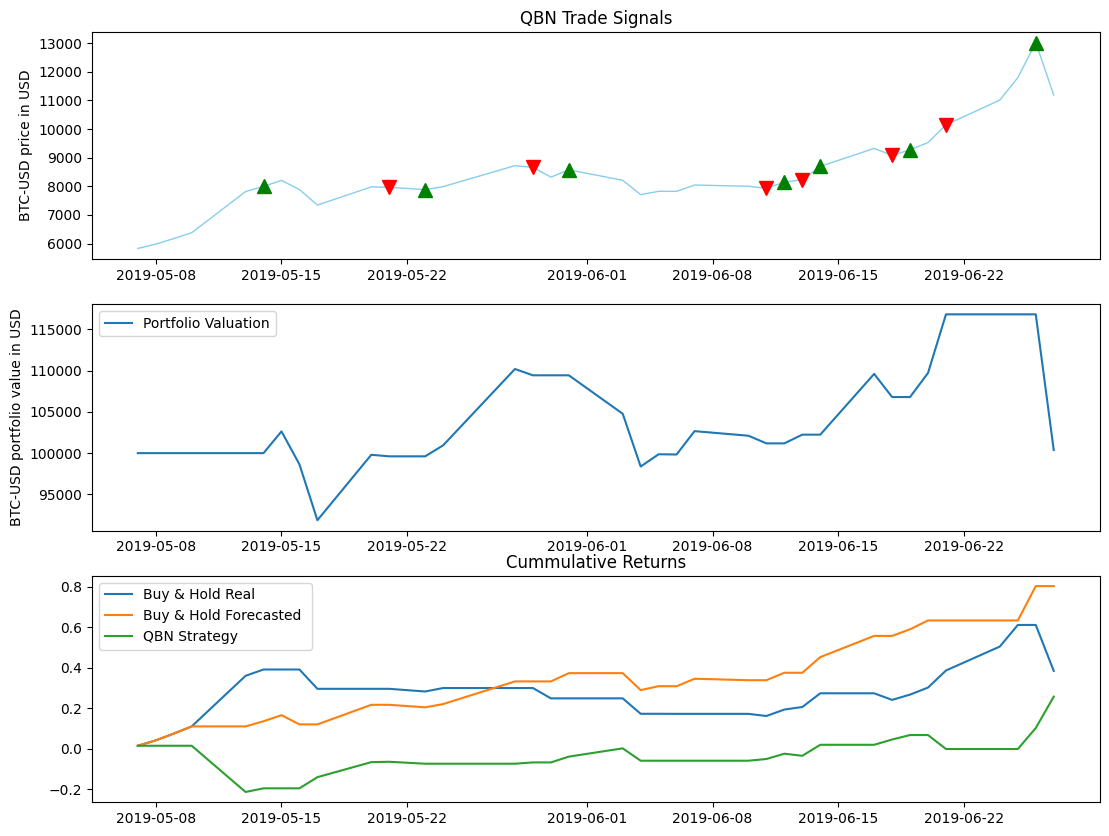

In [33]:
stock_prices = test_quantum_data['prices']
profit = (test_quantum_data['port_value'].iloc[-1]-initial_cash)
print("Total profit {}USD with return of {}%".format(round(profit,2),round(profit*100/initial_cash,2)))

plt.figure(figsize=(13,10))

plt.subplot(3,1,1)
plt.plot(stock_prices, linewidth =1, color = 'skyblue', label = target)
plt.plot(stock_prices.index, BUY_PRICE_TEST, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
plt.plot(stock_prices.index, SELL_PRICE_TEST, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
plt.ylabel('{} price in USD'.format(target))
plt.title('QBN Trade Signals')


plt.subplot(3,1,2)
plt.plot(test_strategy.index,test_strategy['port_value'])
plt.legend(['Portfolio Valuation'])
plt.ylabel('{} portfolio value in USD'.format(target))

plt.subplot(3,1,3)
plt.title('Cummulative Returns')
plt.plot(test_strategy.index,(1+test_strategy['returns']*test_strategy['actual']).cumprod()-1)
plt.plot(test_strategy.index,(1+test_strategy['returns']*test_strategy['forecast']).cumprod()-1)
plt.plot(test_strategy.index,(1+test_strategy['returns']*test_strategy['signals']).cumprod()-1)
plt.legend(['Buy & Hold Real','Buy & Hold Forecasted ','QBN Strategy'])


plt.show()

In [35]:
test_strategy['forecast'].value_counts()

forecast
1    23
0    13
Name: count, dtype: int64

In [36]:
test_strategy['actual'].value_counts()

actual
1    23
0    13
Name: count, dtype: int64